In [193]:
# Utils
import matplotlib.pyplot as plt
import numpy as np
import functools

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.forward_ad as fwAD
import functorch

# For datasets
import torchvision
import torchvision.transforms as transforms
from sklearn import datasets
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

## **FORWARD GRADIENT**
Given a function $f:\mathbb{R}^n\to\mathbb{R}$, the forward gradient $\mathbf{g}:\mathbb{R}^n\to\mathbb{R}^n$ is defined as:
$$\mathbf{g}_\mathbf{v}(x):= \nabla_\mathbf{v} f(x)\cdot\mathbf{v}=(\nabla f(x)\cdot\mathbf{v})\mathbf{v}$$
where $x\in\mathbb{R}^n$ is the point at which we are evaluating
the gradient, $\mathbf{v}\in\mathbb{R}^n$ is a perturbation vector taken as a multivariate random variable $\mathbf{v}\backsim p(\mathbf{v})$ such that $\mathbf{v}$’s scalar components $v_i$ are independent and have zero mean and unit variance for all $i$, and $\nabla f(x)\cdot\mathbf{v}\in\mathbb{R}$ is the directional
derivative of $f$ at point $x$ in direction $\mathbf{v}$.

Moreover, the *forward gradient* $\mathbf{g}_\mathbf{v}(x)$ is an unbiased estimator of the gradient $\nabla f(x)$.

##### **Example [1.1]**
Let's try to perform **forward gradient descent** using the *forward gradients* on the [sum squares function](https://www.sfu.ca/~ssurjano/sumsqu.html):

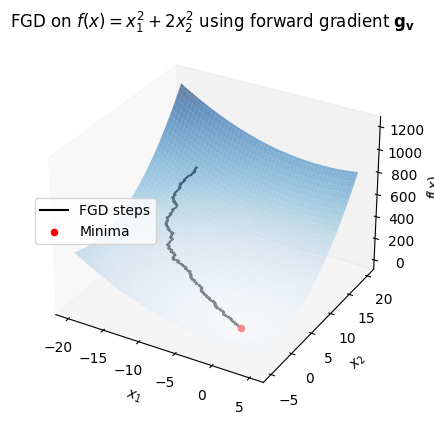

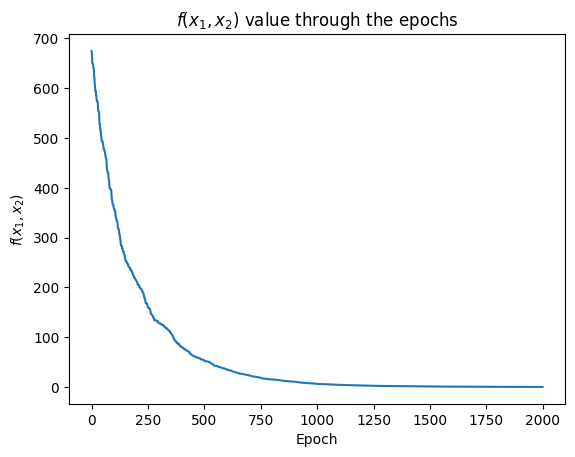

In [194]:
# Define the function
def f1(x1, x2):
    return x1**2 + 2*x2**2 
    
# Define x1, x2, primals and v as canonic base
x1 = torch.tensor([-15.])
x2 = torch.tensor([15.])
primals = (x1, x2)
v_canonic = [tuple([torch.ones(x1.shape) if i==j else torch.zeros(x1.shape) for i in range(len(primals))]) for j in range(len(primals))]

# Define learning rate and number of epochs
l_rate = 0.01
epochs = 2000

# Initialize list of x values, y values, fwd grads and true grads:
x_values = list()
y_values = list()
fwd_grads = list()
true_grads = list()

# Perform FDG (forward gradient descent)
for i in range(epochs):
    # Sample perturbation
    v_params = tuple([torch.rand_like(p) for p in primals])
    # Compute f and df
    val, jvp = functorch.jvp(f1, primals, v_params)
    y_values.append(val)
    # Parameters update using forward gradient
    x_values.append([p.sub_(l_rate * jvp * v_params[j]).item() for j, p in enumerate(primals)])
    # Save true gradients and fwd gradients
    fwd_grads.append([jvp * v_params[j] for j, p in enumerate(primals)])
    true_grads.append([functorch.jvp(f1, primals, v)[1].item() for v in v_canonic])

# Transform to numpy lists
x_values = np.array(x_values)
fwd_grads = np.array(fwd_grads)
true_grads = np.array(true_grads)

# Define the parameters for the plot
t1 = np.linspace(-20, 5, 100)
t2 = np.linspace(-5, 20, 100)
T1, T2 = np.meshgrid(t1, t2)

# Create a plot, disable grid, and add a title
ax = plt.axes(projection='3d')
ax.grid(False)
plt.title(r"FGD on $f(x)=x_1^2+2x_2^2$ using forward gradient $\mathbf{g}_\mathbf{v}$")

# Plot f, GD steps and minima
ax.plot_surface(T1, T2, f1(T1, T2), cmap='Blues', alpha=0.6)
ax.plot(x_values[:, 0], x_values[:, 1], f1(*x_values.T), '-', color='black', label="FGD steps", alpha=1)
ax.scatter(0, 0, 0, color='r', label='Minima')

# Add labels and legend
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$f(x)$')
plt.legend(loc='center left')
plt.show()

# Plot f(x) through the epochs
plt.title(r'$f(x_1, x_2)$ value through the epochs')
plt.xlabel("Epoch")
plt.ylabel(r'$f(x_1, x_2)$')
plt.plot(y_values)

As can be seen from the graph, although noisily, the forward gadient descent algorithm manages to converge at a minimum.
Let us now actually analyze how far the forward gradient approximation deviates from the true value:

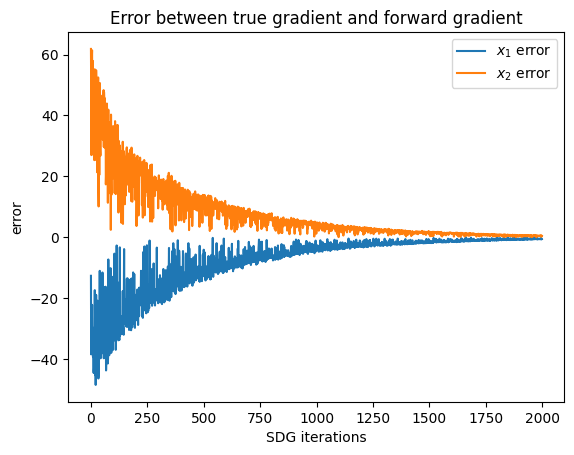

In [195]:
plt.plot(true_grads[:,0]-fwd_grads[:,0], label=r'$x_1$ error')
plt.plot(true_grads[:,1]-fwd_grads[:,1], label=r'$x_2$ error')

plt.title(r"Error between true gradient and forward gradient")
plt.xlabel(r'SDG iterations')
plt.ylabel('error')
plt.legend()
plt.show()

As can be seen from the graph, as the minimum of the function is approached, the difference between the forward gradient and the true gradient of the function is reduced. This is mainly due to the reduction of the gradient near the minimum.

---

Let's now try to apply the forward gradient to a CNN.

In [ ]:
##################

Since the gradient computation with respect to some Pytorch function is not fully supported yet, we first need to define some elementary operations using tensors:

---
The stable cross entropy will be used by the *functorch.jvp* function, that will input only primals and tangents to it. Since our cross entropy also requires "params" and "func" to be specified, we will need to use *functool.partial*: this function will create a new callable function that behave like cross entropy but has 2 positional arguments less (params and funct indeed). The missing arguments will be always substituted by the one specified when calling *functool.partial*.

To extract the parameters of the model, we will use the *torch.make_functional* function, that given a *torch.nn.Module* extracts the state (params) and returns a functional version of the model.
For the perturbation vector, we will use the *torch.rand_like* function, that returns a tensor with the same size as input that is filled with random numbers from a normal distribution with mean 0 and variance 1.

In [196]:
def stable_softmax(x):
    shift_inputs = x - torch.max(x, dim=-1, keepdim=True)[0]
    exponentiated = torch.exp(shift_inputs)
    sum_exponentiated = torch.sum(exponentiated, dim=-1, keepdim=True)
    return torch.div(exponentiated, sum_exponentiated)

def stable_cross_entropy(params, func, x, t):
    _, prediction = torch.max(func(params, x).data, 1)
    log_probs = torch.log(stable_softmax(prediction))
    stable_ce = -torch.sum(log_probs * t, dim=-1)
    return stable_ce

Now let's define a CNN

In [197]:
# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [198]:
# Load the iris dataset and convert the numpy arrays to PyTorch tensors
iris = datasets.load_iris()
X = torch.from_numpy(iris.data).float()
y = torch.from_numpy(iris.target).long()

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create TensorDatasets for training and test sets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Define batch_size
batch_size = 32

# Create DataLoaders for training and test sets
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [199]:
model = Net(input_size=4, output_size=3)
l_rate = 1e-1
num_epochs = 50
num_classes = 3

Epoch 0, loss: 79.45135498046875
Epoch 10, loss: 95.34161376953125
Epoch 20, loss: 50.84885787963867
Epoch 30, loss: 73.0952377319336
Epoch 40, loss: 79.45134735107422
Finished Training


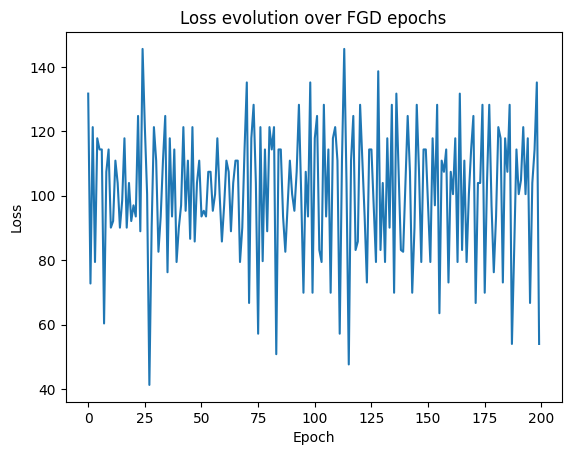

In [200]:
# Initialize empty loss list (to plot losses over epochs)
losses = list()

with torch.no_grad():
    # Get the functional version of the model with functorch
    func, params = functorch.make_functional(model)

    # Train the network with FGD (forward Gradient Descent)
    for epoch in range(num_epochs): 
        for i, (inputs, labels) in enumerate(train_dataloader):   
            # Create callable CE function
            f = functools.partial(stable_cross_entropy, func=func, x=inputs, t=labels)
            
            # Sample perturbation (for each parameter of the model)
            v_params = tuple([torch.randn_like(p) for p in params])            
            
            # Forward AD
            loss, jvp = functorch.jvp(f, (tuple(params),), (v_params,))
            losses.append(loss)

            # For each parameter
            for j, p in enumerate(params):
                # Compute forward gradient
                g = jvp * v_params[j]
                # Parameters update
                p = p - l_rate * g 

        if epoch % 10 == 0: print(f'Epoch {epoch}, loss: {losses[-1]}')

    print('Finished Training')

plt.title("Loss evolution over FGD epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(losses)

### References

[1] [Derivative](https://en.wikipedia.org/wiki/Derivative).

[2] Kofi Asiedu Brempong, 2020 [I Finally Understood Backpropagation: And you can too...](https://towardsdatascience.com/i-finally-understood-backpropagation-and-you-can-too-44f7dd98ff52).

[3] Atılım Gunes Baydin, Barak A. Pearlmutter, Don Syme, Frank Wood, Philip Torr, 2022. [Gradients without Backpropagation](https://arxiv.org/abs/2005.00817).

[4] [Dual number](https://en.wikipedia.org/wiki/Dual_number).

[5] Mark Saroufim, 2019. [Automatic Differentiation Step by Step](https://marksaroufim.medium.com/automatic-differentiation-step-by-step-24240f97a6e6).

[6] Robert Lange, 2019. [Forward Mode Automatic Differentiation & Dual Numbers](https://towardsdatascience.com/forward-mode-automatic-differentiation-dual-numbers-8f47351064bf).

[7] [Automatic Differentiation in Machine Learning: a Survey](https://www.jmlr.org/papers/volume18/17-468/17-468.pdf).

[8] Daniel Worrall, 2021. [Dual numbers](https://danielewworrall.github.io/blog/2021/08/dual-numbers/)

[9] Dr. Robert Kübler, 2022. [Papers Simplified: Gradients without Backpropagation](https://towardsdatascience.com/papers-simplified-gradients-without-backpropagation-96e8533943fc).